In [2]:
import comet_ml
experiment = comet_ml.start()

from policy_bench.util import setup_cache, setup_logging
setup_logging()
setup_cache()
import logging
logger = logging.getLogger("policy_bench")
logger.setLevel('INFO')

import argon.random
import argon.transforms as agt
import argon.numpy as npx
import argon.ott.sinkhorn as sinkhorn
import argon.ott as ott
import argon.train
import argon.tree
import argon.random
import argon.policy as policy
import argon.random

from argon.train import LossOutput
from argon.random import PRNGSequence
from argon.data import PyTreeData
from argon.diffusion.ddpm import DDPMSchedule

import argon.store.comet

import jax
import optax
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

import argon.store
import sklearn.metrics
import chex
import pickle

from sklearn.linear_model import LinearRegression

from argon.struct import struct

from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pfrommerd/general/df4a456352d649b8ad45d37e6c55252d



In [3]:
from policy_bench.methods.diffusion_policy import DiffusionPolicy

artifact = experiment.get_artifact("lower_bound-stable-1-diffusion_policy:7.0.0")
checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)
artifact = experiment.get_artifact("lower_bound-stable-1-diffusion_policy:11.0.0")
mc_checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)
artifact = experiment.get_artifact("lower_bound-stable-1-diffusion_policy:8.0.0")
hc_checkpoint : DiffusionPolicy = argon.store.comet.from_artifact(artifact)

In [4]:
from argon.registry import Registry
from policy_bench.envs.lower_bounds import register_envs
dataset = checkpoint.data.create_dataset()
registry = Registry()
register_envs(registry)
env_alt = registry.create("lower_bound/stable/2")
env = dataset.env()

In [5]:
def rollout(checkpoint, mc_checkpoint, hc_checkpoint, rng):
    diffusion_policy = checkpoint.create_policy()
    diffusion_policy_mc = mc_checkpoint.create_policy()
    diffusion_policy_hc = hc_checkpoint.create_policy()
    @agt.partial
    def zero_policy(input):
        return policy.PolicyOutput(npx.zeros_like(input.state))
    x0 = env.reset(rng)
    x0 = npx.concatenate((npx.array([0.05, 0]), x0[2:]))
    r_dp = policy.rollout(agt.partial(env.step), x0, diffusion_policy, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    r_dp_mc = policy.rollout(agt.partial(env.step), x0, diffusion_policy_mc, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    r_dp_hc = policy.rollout(agt.partial(env.step), x0, diffusion_policy_hc, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    r_exp = policy.rollout(agt.partial(env.step), x0, zero_policy, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    alt_r_dp = policy.rollout(agt.partial(env_alt.step), x0, diffusion_policy, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    alt_r_dp_mc = policy.rollout(agt.partial(env_alt.step), x0, diffusion_policy_mc, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    alt_r_dp_hc = policy.rollout(agt.partial(env_alt.step), x0, diffusion_policy_hc, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    alt_r_exp = policy.rollout(agt.partial(env_alt.step), x0, zero_policy, length=100, 
                   policy_rng_key=argon.random.key(42)).states
    return (
        r_dp, r_dp_mc, r_dp_hc, r_exp,
        alt_r_dp, alt_r_dp_mc, alt_r_dp_hc, alt_r_exp
    )

# rollout(checkpoint, argon.random.key(42))
(dp_trajs, dp_mc_trajs, dp_hc_trajs, zero_trajs,
    alt_dp_trajs, alt_dp_mc_trajs, alt_dp_hc_trajs, alt_zero_trajs) = agt.vmap(
        rollout, in_axes=(None, None, None, 0)
    )(
        checkpoint, mc_checkpoint, hc_checkpoint,
        argon.random.split(
            argon.random.key(42), 2
        )
    )

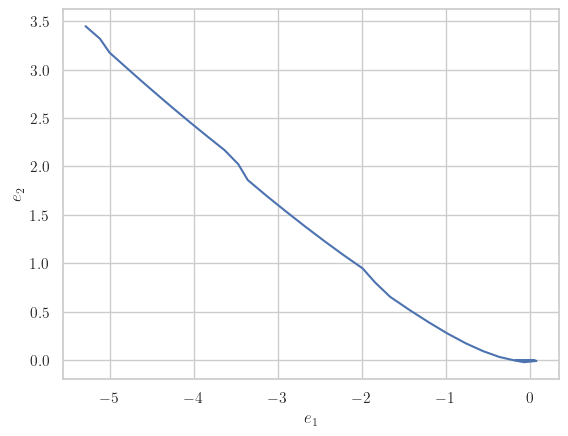

In [6]:
import itertools
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
T = 30
for (dp_traj, mc_traj, hc_traj, zero_traj, 
     alt_dp_traj, alt_mc_traj, alt_hc_traj, alt_zero_traj,
     color) in zip(
                dp_trajs, dp_mc_trajs, dp_hc_trajs, zero_trajs, 
                alt_dp_trajs, alt_dp_mc_trajs, alt_dp_hc_trajs, alt_zero_trajs,
                itertools.cycle(colors)
            ):
    plt.plot(dp_traj[:T, 0], dp_traj[:T, 1], marker=None, color=color)
    # plt.plot(mc_traj[:T, 0], mc_traj[:T, 1], marker=None, color=color)
    # plt.plot(hc_traj[:T, 0], hc_traj[:T, 1], marker=None, color=color)
    # plt.plot(zero_traj[:, 0], zero_traj[:, 1], marker=None, color=color)

    plt.plot(alt_dp_traj[:T:2, 0], alt_dp_traj[:T:2, 1], marker=None, linestyle="--", color=color)
    # plt.plot(alt_mc_traj[:T:2, 0], alt_mc_traj[:T:2, 1], marker=None, linestyle="--", color=color)
    # plt.plot(alt_hc_traj[:T, 0], alt_hc_traj[:T, 1], marker=None, color=color)
    # plt.plot(alt_zero_traj[:, 0], alt_zero_traj[:, 1], marker=None, color=color)
    break

# plt.xlim(-0.6, 0.6)
# plt.ylim(-0.4, 0.4)
plt.xlabel("$e_1$")
plt.ylabel("$e_2$")
plt.show()


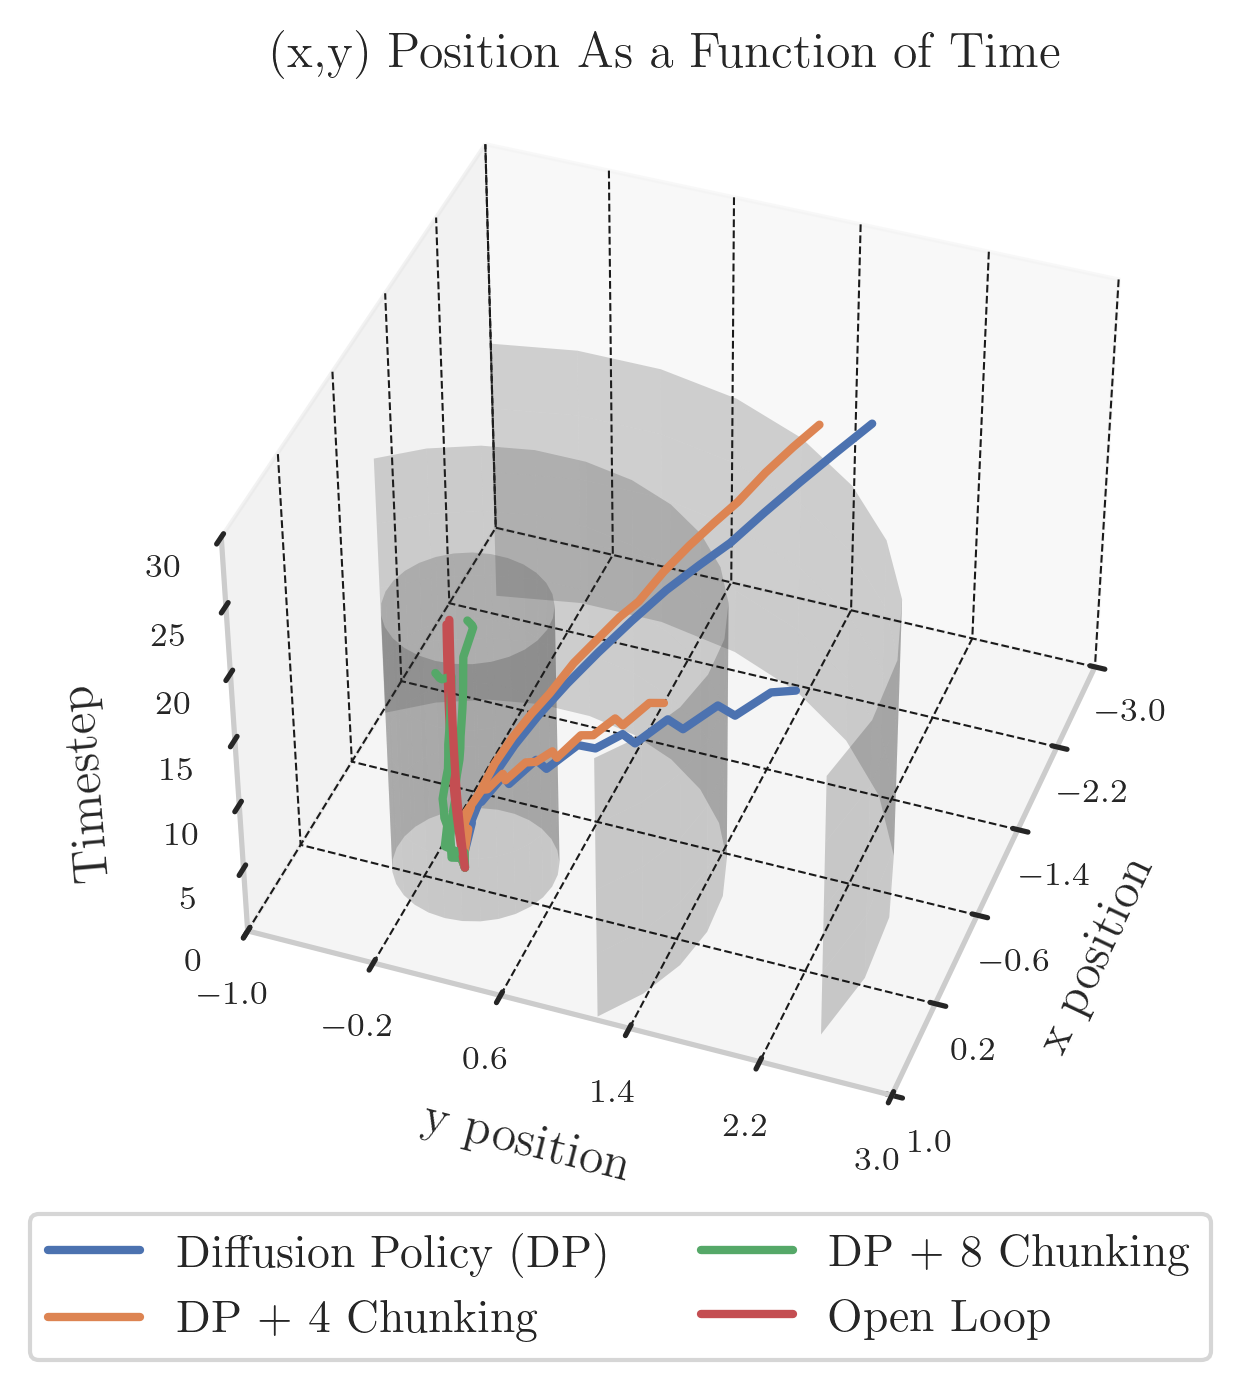

In [ ]:
import itertools
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
T = 20
alt = -((npx.arange(T) % 2) * 2 - 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.view_init(elev=40, azim=20, roll=0)

def plot_cylinder(ax, center, radius, color):
    theta = npx.linspace(0, 2 * npx.pi, 30)
    z = npx.linspace(0, 20, 5)
    Theta, Z = npx.meshgrid(theta, z)
    X = radius * npx.cos(Theta) + center[0]
    Y = radius * npx.sin(Theta) + center[1]
    # ax.plot_wireframe(X, Y, Z, color=color, alpha=0.5, rstride=1, cstride=5, edgecolor=color)
    ax.plot_surface(X, Y, Z, color=color, alpha=0.2, edgecolor='none', axlim_clip=True,
                    zorder=-10.0)
plot_cylinder(ax, (0, 0.05), 0.5, (0.2, 0.2, 0.2, 0))
plot_cylinder(ax, (0, 0.05), 1.5, (0.2, 0.2, 0.2, 0))
plot_cylinder(ax, (0, 0.05), 2.5, (0.2, 0.2, 0.2, 0))
c = npx.inf
ts = npx.arange(T)
for (dp_traj, mc_traj, hc_traj, zero_traj, 
     alt_dp_traj, alt_mc_traj, alt_hc_traj, alt_zero_traj,
     color) in zip(
                dp_trajs, dp_mc_trajs, dp_hc_trajs, zero_trajs, 
                alt_dp_trajs, alt_dp_mc_trajs, alt_dp_hc_trajs, alt_zero_trajs,
                itertools.cycle(colors)
            ):
    clip = True
    width = 2
    ax.plot(dp_traj[:T, 0], dp_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[0], label="Diffusion Policy (DP)")
    ax.plot(mc_traj[:T, 0], mc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[1], label="DP + 4 Chunking")
    ax.plot(hc_traj[:T, 0], hc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[2], label="DP + 8 Chunking")
    ax.plot(zero_traj[:T, 0], zero_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[3], label="Open Loop")
    ax.plot(alt_dp_traj[:T, 0]*alt, dp_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[0])
    ax.plot(alt_mc_traj[:T, 0]*alt, mc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[1])
    ax.plot(alt_hc_traj[:T, 0]*alt, hc_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[2])
    ax.plot(alt_zero_traj[:T, 0]*alt, zero_traj[:T, 1], ts, axlim_clip=clip, linewidth=width,
             marker=None, color=colors[3])
    break

fig.legend(loc="lower center", ncol=2)
ax.set_xlabel("x position", labelpad=0)
ax.set_ylabel("y position", labelpad=0)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel("Timestep", rotation=95, labelpad=0)
sx = -3.0, 1.0
sy = -1, 3
ax.set_xlim(sx[0], sx[1])
ax.set_ylim(sy[0], sy[1])
ax.set_zlim(0, 30)

ax.set_xticks(npx.linspace(sx[0], sx[1], 6))
ax.set_yticks(npx.linspace(sy[0], sy[1], 6))

ax.tick_params(axis="x", pad=0, labelsize=8)
ax.tick_params(axis="y", pad=0, labelsize=8)
ax.tick_params(axis="z", pad=0, labelsize=8)

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 0.1
    axis._axinfo['axisline']['color'] = (0.2, 0.2, 0.2)
    axis._axinfo['grid']['linewidth'] = 0.5
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = (0.1, 0.1, 0.1)
    # axis._axinfo['tick']['inward_factor'] = 0.0
    # axis._axinfo['tick']['outward_factor'] = 0.0

ax.zaxis._axinfo["grid"].update({"color": (1., 1., 1., 0.)})

ax.set_title("(x,y) Position As a Function of Time")
fig.tight_layout()
fig.subplots_adjust(left=0.25, right=0.8, top=0.9, bottom=0.15)
fig.set_dpi(300)
fig.show()

fig.savefig("open_loop_stable.pdf", bbox_inches='tight', pad_inches=0.1)